In [0]:
!pip install keras
!pip install sklearn
!pip install matplotlib
!pip install -U -q PyDrive

In [0]:
from keras import backend as K
K.clear_session()

Using TensorFlow backend.


In [0]:
from keras import backend as K
cfg = K.tf.ConfigProto()
cfg.gpu_options.allow_growth = True
K.set_session(K.tf.Session(config=cfg))

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
file_import = drive.CreateFile({'id':'1p1bsltfTcIrZ_kfE6kwGTPzcdXorHbb2'})
file_import.GetContentFile('colab_setup.py') 
from colab_setup import setup

setup(drive)

In [0]:
!ls

colab_setup.py			 roc_auc_callback.py	X_train.npy
custom_fast_text_embeddings.npy  sample_submission.csv	X_val.npy
datalab				 train_model.py		y_test.npy
fast_text_embeddings.npy	 X_submission.npy	y_train_full.npy
plot_history.py			 X_test.npy		y_train.npy
__pycache__			 X_train_full.npy	y_val.npy


In [0]:
import numpy as np
import os

from plot_history import plot_history
from roc_auc_callback import RocAucCallback
from train_model import train_with_cv, train_with_submitting, evaluate_on_test

from keras.layers import *
from keras.layers.merge import *
from keras.initializers import *
from keras.models import Model

In [0]:
from keras.optimizers import *
from keras.initializers import *
from keras.layers import *
from keras.layers.merge import *
from keras.models import *

residual_convolution_options = dict({
    'dropout_mode': 'spatial',
    'dropout_rate': 0.2,
    'filters': 300,
    'kernel_size': 1,
    'strides': 1,
    'padding': 'same',
    'activation': 'elu',
    'should_preactivate': True
})

def convolution_block(input_layer, options):
    convolution_input = Input(shape=[
        int(input_layer.shape[1]),
        int(input_layer.shape[2])
    ])

    convolution_block = convolution_input

    if(options['should_preactivate']):
        convolution_block = BatchNormalization()(convolution_block)
        convolution_block = Activation(options['activation'])(convolution_block)
        convolution_block = Conv1D(options['filters'], options['kernel_size'], strides=options['strides'],
                                   padding=options['padding'], activation='linear', kernel_initializer='he_normal')(convolution_block)
    else:
        convolution_block = Conv1D(options['filters'], options['kernel_size'], strides=options['strides'],
                                   padding=options['padding'], activation='linear', kernel_initializer='he_normal')(convolution_block)
        convolution_block = BatchNormalization()(convolution_block)
        convolution_block = Activation(options['activation'])(convolution_block)

    convolution_output = convolution_block

    if(options['dropout_mode'] == 'spatial'):
        convolution_output = SpatialDropout1D(options['dropout_rate'])(convolution_output)
    if(options['dropout_mode']== 'vanilla'):
        convolution_output = Dropout(options['dropout_rate'])(convolution_output)

    return Model(inputs=[convolution_input], outputs=[convolution_output])(input_layer)

In [0]:
def residual_block(input_layer, should_pool):
    convolution_input = Input(shape=[
        int(input_layer.shape[1]),
        int(input_layer.shape[2])
    ])
    residual_block = convolution_input

    if(should_pool):
        residual_block = MaxPooling1D(pool_size=2, strides=2, padding='same')(residual_block)

    residual_block = convolution_block(
        residual_block, residual_convolution_options)
    residual_block = convolution_block(
        residual_block, residual_convolution_options)

    convolution_output = add([residual_block, convolution_input])

    return Model(inputs=[convolution_input], outputs=[convolution_output])(input_layer)

In [0]:
def yoon_kim_feature_extractor(input_layer, filters):
    extractor_block_input = Input(shape=[
        int(input_layer.shape[1]),
        int(input_layer.shape[2])
    ])

    block_1_conv_1 = Conv1D(filters, 1, activation = 'linear', padding = 'same', kernel_initializer = 'he_normal')(extractor_block_input)
    block_1_batchnorm1 = BatchNormalization()(block_1_conv_1)
    block_1_batchnorm1 = ELU()(block_1_batchnorm1)
    block_1_max_pool1 = GlobalMaxPooling1D()(block_1_batchnorm1)

    block_1_conv_2 = Conv1D(filters, 2, activation = 'linear', padding = 'same', kernel_initializer = 'he_normal')(extractor_block_input)
    block_1_batchnorm2 = BatchNormalization()(block_1_conv_2)
    block_1_batchnorm2 = ELU()(block_1_batchnorm2)
    block_1_max_pool2 = GlobalMaxPooling1D()(block_1_batchnorm2)

    block_1_conv_3 = Conv1D(filters, 3, activation = 'linear', padding = 'same', kernel_initializer = 'he_normal')(extractor_block_input)
    block_1_batchnorm3 = BatchNormalization()(block_1_conv_3)
    block_1_batchnorm3 = ELU()(block_1_batchnorm3)
    block_1_max_pool3 = GlobalMaxPooling1D()(block_1_batchnorm3)

    block_1_conv_4 = Conv1D(filters, 5, activation = 'linear', padding = 'same', kernel_initializer = 'he_normal')(extractor_block_input)
    block_1_batchnorm4 = BatchNormalization()(block_1_conv_4)
    block_1_batchnorm4 = ELU()(block_1_batchnorm4)
    block_1_max_pool4 = GlobalMaxPooling1D()(block_1_batchnorm4)

    features = concatenate([
        block_1_max_pool1, 
        block_1_max_pool2, 
        block_1_max_pool3, 
        block_1_max_pool4
    ])
    
    extractor_block_output = Dropout(0.2)(features)
    
    return Model(
        inputs=[extractor_block_input], 
        outputs=[extractor_block_output]
    )(input_layer)

In [0]:
def classification_block(input_layer, dropout_rate = 0.2):
      
    model = Dense(256, activation = 'linear', kernel_initializer = 'he_normal')(input_layer)
    model = BatchNormalization()(model)
    model = ELU()(model)
    model = Dropout(dropout_rate)(model)
    
    model = Dense(256, activation = 'linear', kernel_initializer = 'he_normal')(model)
    model = BatchNormalization()(model)
    model = ELU()(model)
    model = Dropout(dropout_rate)(model)

    classification_block_output = Dense(6, activation='sigmoid', kernel_initializer = 'glorot_normal')(model)
    
    return classification_block_output

In [0]:
max_words= 30000
max_words_length = 400
embedding_dimension = 300

input_layer = Input(shape=(max_words_length,))

pretrained_embedding_layer = Embedding(
    max_words, 
    output_dim=embedding_dimension, 
    input_length=max_words_length,
    trainable = False
)(input_layer)
pretrained_embedding_layer = SpatialDropout1D(0.2)(pretrained_embedding_layer)

custom_embedding_layer = Embedding(
    max_words, 
    output_dim=embedding_dimension, 
    input_length=max_words_length,
    trainable = False
)(input_layer)

custom_embedding_layer = SpatialDropout1D(0.2)(custom_embedding_layer)

averaged_embedding_layer = Average()([pretrained_embedding_layer, custom_embedding_layer])
averaged_embedding_layer = SpatialDropout1D(0.2)(averaged_embedding_layer)

model = residual_block(averaged_embedding_layer, should_pool = False)
model = residual_block(model, should_pool = False)

output_layer = yoon_kim_feature_extractor(model, residual_convolution_options['filters'])
output_layer = classification_block(output_layer)

model = Model(input_layer, output_layer)

model.compile(loss='binary_crossentropy', 
            optimizer='Adam',
            metrics=['accuracy'])          

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 400)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 400, 300)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
spatial_dr

In [0]:
history = train_with_cv(model, batchSize=32, rocEvery = 2)

Train on 102124 samples, validate on 25532 samples
Epoch 1/32
 21408/102124 [=====>........................] - ETA: 7:00 - loss: 0.1627 - acc: 0.9508

102112/102124 [============================>.] - ETA: 0s - loss: 0.1064 - acc: 0.9685

102124/102124 [==============================] - 555s 5ms/step - loss: 0.1064 - acc: 0.9685 - val_loss: 0.0738 - val_acc: 0.9767
Epoch 2/32
 14048/102124 [===>..........................] - ETA: 7:21 - loss: 0.0824 - acc: 0.9757

102112/102124 [============================>.] - ETA: 0s - loss: 0.0760 - acc: 0.9763

102124/102124 [==============================] - 550s 5ms/step - loss: 0.0760 - acc: 0.9763 - val_loss: 0.0666 - val_acc: 0.9790
roc-auc: 0.9552 - roc-auc_val: 0.9518                                                                                                    
Epoch 3/32
  8736/102124 [=>............................] - ETA: 7:48 - loss: 0.0705 - acc: 0.9770

102112/102124 [============================>.] - ETA: 0s - loss: 0.0680 - acc: 0.9779

102124/102124 [==============================] - 551s 5ms/step - loss: 0.0680 - acc: 0.9779 - val_loss: 0.0616 - val_acc: 0.9801
Epoch 4/32
 14048/102124 [===>..........................] - ETA: 7:21 - loss: 0.0639 - acc: 0.9790

102112/102124 [============================>.] - ETA: 0s - loss: 0.0641 - acc: 0.9787

102124/102124 [==============================] - 550s 5ms/step - loss: 0.0641 - acc: 0.9787 - val_loss: 0.0577 - val_acc: 0.9807
roc-auc: 0.9683 - roc-auc_val: 0.9627                                                                                                    
Epoch 5/32
  8736/102124 [=>............................] - ETA: 7:48 - loss: 0.0612 - acc: 0.9794

102112/102124 [============================>.] - ETA: 0s - loss: 0.0609 - acc: 0.9795

102124/102124 [==============================] - 550s 5ms/step - loss: 0.0609 - acc: 0.9795 - val_loss: 0.0555 - val_acc: 0.9814
Epoch 6/32
 14048/102124 [===>..........................] - ETA: 7:21 - loss: 0.0610 - acc: 0.9796

102112/102124 [============================>.] - ETA: 0s - loss: 0.0589 - acc: 0.9800

102124/102124 [==============================] - 551s 5ms/step - loss: 0.0589 - acc: 0.9800 - val_loss: 0.0535 - val_acc: 0.9816
roc-auc: 0.9746 - roc-auc_val: 0.9694                                                                                                    
Epoch 7/32
  8736/102124 [=>............................] - ETA: 7:48 - loss: 0.0575 - acc: 0.9808

102112/102124 [============================>.] - ETA: 0s - loss: 0.0572 - acc: 0.9805

102124/102124 [==============================] - 551s 5ms/step - loss: 0.0572 - acc: 0.9805 - val_loss: 0.0523 - val_acc: 0.9819
Epoch 8/32
 14048/102124 [===>..........................] - ETA: 7:21 - loss: 0.0551 - acc: 0.9812

102112/102124 [============================>.] - ETA: 0s - loss: 0.0551 - acc: 0.9810

102124/102124 [==============================] - 551s 5ms/step - loss: 0.0551 - acc: 0.9810 - val_loss: 0.0518 - val_acc: 0.9822
roc-auc: 0.9793 - roc-auc_val: 0.9729                                                                                                    
Epoch 9/32
  8736/102124 [=>............................] - ETA: 7:48 - loss: 0.0517 - acc: 0.9812

102112/102124 [============================>.] - ETA: 0s - loss: 0.0535 - acc: 0.9811

102124/102124 [==============================] - 551s 5ms/step - loss: 0.0535 - acc: 0.9811 - val_loss: 0.0503 - val_acc: 0.9822
Epoch 10/32
 13984/102124 [===>..........................] - ETA: 7:21 - loss: 0.0520 - acc: 0.9815

102112/102124 [============================>.] - ETA: 0s - loss: 0.0523 - acc: 0.9815

102124/102124 [==============================] - 551s 5ms/step - loss: 0.0523 - acc: 0.9815 - val_loss: 0.0501 - val_acc: 0.9827
roc-auc: 0.9827 - roc-auc_val: 0.9751                                                                                                    
Epoch 11/32
  8704/102124 [=>............................] - ETA: 7:49 - loss: 0.0526 - acc: 0.9816

102112/102124 [============================>.] - ETA: 0s - loss: 0.0515 - acc: 0.9817

102124/102124 [==============================] - 552s 5ms/step - loss: 0.0515 - acc: 0.9817 - val_loss: 0.0493 - val_acc: 0.9825
Epoch 12/32
 13984/102124 [===>..........................] - ETA: 7:22 - loss: 0.0525 - acc: 0.9813

102112/102124 [============================>.] - ETA: 0s - loss: 0.0503 - acc: 0.9820

102124/102124 [==============================] - 551s 5ms/step - loss: 0.0503 - acc: 0.9820 - val_loss: 0.0491 - val_acc: 0.9825
roc-auc: 0.9853 - roc-auc_val: 0.9775                                                                                                    
Epoch 13/32
  8704/102124 [=>............................] - ETA: 7:47 - loss: 0.0504 - acc: 0.9821

102112/102124 [============================>.] - ETA: 0s - loss: 0.0494 - acc: 0.9823

102124/102124 [==============================] - 551s 5ms/step - loss: 0.0494 - acc: 0.9823 - val_loss: 0.0488 - val_acc: 0.9827
Epoch 14/32
 13984/102124 [===>..........................] - ETA: 7:21 - loss: 0.0488 - acc: 0.9825

102112/102124 [============================>.] - ETA: 0s - loss: 0.0484 - acc: 0.9824

102124/102124 [==============================] - 551s 5ms/step - loss: 0.0484 - acc: 0.9824 - val_loss: 0.0476 - val_acc: 0.9827
roc-auc: 0.9869 - roc-auc_val: 0.9781                                                                                                    
Epoch 15/32
  8704/102124 [=>............................] - ETA: 7:48 - loss: 0.0482 - acc: 0.9827

102112/102124 [============================>.] - ETA: 0s - loss: 0.0477 - acc: 0.9827

102124/102124 [==============================] - 551s 5ms/step - loss: 0.0477 - acc: 0.9827 - val_loss: 0.0479 - val_acc: 0.9832
Epoch 16/32
 13984/102124 [===>..........................] - ETA: 7:21 - loss: 0.0489 - acc: 0.9826

102112/102124 [============================>.] - ETA: 0s - loss: 0.0473 - acc: 0.9830

102124/102124 [==============================] - 550s 5ms/step - loss: 0.0473 - acc: 0.9830 - val_loss: 0.0472 - val_acc: 0.9834
roc-auc: 0.988 - roc-auc_val: 0.9793                                                                                                    
Epoch 17/32
  8736/102124 [=>............................] - ETA: 7:48 - loss: 0.0455 - acc: 0.9830

102112/102124 [============================>.] - ETA: 0s - loss: 0.0464 - acc: 0.9828

102124/102124 [==============================] - 551s 5ms/step - loss: 0.0464 - acc: 0.9828 - val_loss: 0.0475 - val_acc: 0.9831
Epoch 18/32
 13984/102124 [===>..........................] - ETA: 7:22 - loss: 0.0458 - acc: 0.9832

102112/102124 [============================>.] - ETA: 0s - loss: 0.0462 - acc: 0.9832

102124/102124 [==============================] - 551s 5ms/step - loss: 0.0462 - acc: 0.9832 - val_loss: 0.0478 - val_acc: 0.9832

Epoch 00018: ReduceLROnPlateau reducing learning rate to 8.53775127325207e-05.
roc-auc: 0.9889 - roc-auc_val: 0.9794                                                                                                    
Epoch 19/32
  5984/102124 [>.............................] - ETA: 8:02 - loss: 0.0446 - acc: 0.9843

102112/102124 [============================>.] - ETA: 0s - loss: 0.0456 - acc: 0.9832

102124/102124 [==============================] - 551s 5ms/step - loss: 0.0456 - acc: 0.9831 - val_loss: 0.0461 - val_acc: 0.9833
Epoch 20/32
 13984/102124 [===>..........................] - ETA: 7:21 - loss: 0.0436 - acc: 0.9835

102112/102124 [============================>.] - ETA: 0s - loss: 0.0450 - acc: 0.9834

102124/102124 [==============================] - 551s 5ms/step - loss: 0.0450 - acc: 0.9834 - val_loss: 0.0468 - val_acc: 0.9831
roc-auc: 0.9896 - roc-auc_val: 0.9799                                                                                                    
Epoch 21/32
  8704/102124 [=>............................] - ETA: 7:48 - loss: 0.0438 - acc: 0.9837

102112/102124 [============================>.] - ETA: 0s - loss: 0.0450 - acc: 0.9834

102124/102124 [==============================] - 551s 5ms/step - loss: 0.0450 - acc: 0.9834 - val_loss: 0.0468 - val_acc: 0.9832
Epoch 22/32
 13984/102124 [===>..........................] - ETA: 7:21 - loss: 0.0427 - acc: 0.9846

102112/102124 [============================>.] - ETA: 0s - loss: 0.0448 - acc: 0.9835

102124/102124 [==============================] - 551s 5ms/step - loss: 0.0448 - acc: 0.9835 - val_loss: 0.0474 - val_acc: 0.9834
roc-auc: 0.9899 - roc-auc_val: 0.9799                                                                                                    
Epoch 23/32
  8704/102124 [=>............................] - ETA: 7:48 - loss: 0.0452 - acc: 0.9831

102112/102124 [============================>.] - ETA: 0s - loss: 0.0444 - acc: 0.9838

102124/102124 [==============================] - 551s 5ms/step - loss: 0.0444 - acc: 0.9838 - val_loss: 0.0460 - val_acc: 0.9833
Epoch 24/32
 13984/102124 [===>..........................] - ETA: 7:22 - loss: 0.0448 - acc: 0.9831

102112/102124 [============================>.] - ETA: 0s - loss: 0.0439 - acc: 0.9836

102124/102124 [==============================] - 551s 5ms/step - loss: 0.0438 - acc: 0.9836 - val_loss: 0.0464 - val_acc: 0.9832
roc-auc: 0.9907 - roc-auc_val: 0.9805                                                                                                    
Epoch 25/32
  8704/102124 [=>............................] - ETA: 7:47 - loss: 0.0406 - acc: 0.9851

102112/102124 [============================>.] - ETA: 0s - loss: 0.0436 - acc: 0.9840

102124/102124 [==============================] - 551s 5ms/step - loss: 0.0436 - acc: 0.9840 - val_loss: 0.0461 - val_acc: 0.9835
Epoch 26/32
 13984/102124 [===>..........................] - ETA: 7:21 - loss: 0.0409 - acc: 0.9843

102112/102124 [============================>.] - ETA: 0s - loss: 0.0431 - acc: 0.9840

102124/102124 [==============================] - 550s 5ms/step - loss: 0.0431 - acc: 0.9840 - val_loss: 0.0465 - val_acc: 0.9833
roc-auc: 0.9912 - roc-auc_val: 0.9809                                                                                                    
Epoch 27/32
  8704/102124 [=>............................] - ETA: 7:47 - loss: 0.0437 - acc: 0.9839

102112/102124 [============================>.] - ETA: 0s - loss: 0.0430 - acc: 0.9841

102124/102124 [==============================] - 551s 5ms/step - loss: 0.0430 - acc: 0.9841 - val_loss: 0.0468 - val_acc: 0.9830
Epoch 28/32
 13984/102124 [===>..........................] - ETA: 7:22 - loss: 0.0418 - acc: 0.9845

102112/102124 [============================>.] - ETA: 0s - loss: 0.0427 - acc: 0.9841

102124/102124 [==============================] - 551s 5ms/step - loss: 0.0427 - acc: 0.9841 - val_loss: 0.0461 - val_acc: 0.9833
roc-auc: 0.9914 - roc-auc_val: 0.981                                                                                                    
Epoch 29/32
  8736/102124 [=>............................] - ETA: 7:47 - loss: 0.0415 - acc: 0.9845

102112/102124 [============================>.] - ETA: 0s - loss: 0.0425 - acc: 0.9841

102124/102124 [==============================] - 550s 5ms/step - loss: 0.0425 - acc: 0.9841 - val_loss: 0.0463 - val_acc: 0.9832

Epoch 00029: ReduceLROnPlateau reducing learning rate to 2.7204705475014634e-05.
Epoch 30/32
  8032/102124 [=>............................] - ETA: 7:51 - loss: 0.0424 - acc: 0.9838

102112/102124 [============================>.] - ETA: 0s - loss: 0.0427 - acc: 0.9839

102124/102124 [==============================] - 550s 5ms/step - loss: 0.0427 - acc: 0.9839 - val_loss: 0.0465 - val_acc: 0.9832
roc-auc: 0.9915 - roc-auc_val: 0.9807                                                                                                    
Epoch 31/32
  8704/102124 [=>............................] - ETA: 7:48 - loss: 0.0432 - acc: 0.9837

102112/102124 [============================>.] - ETA: 0s - loss: 0.0425 - acc: 0.9841

102124/102124 [==============================] - 551s 5ms/step - loss: 0.0425 - acc: 0.9841 - val_loss: 0.0463 - val_acc: 0.9834
Epoch 32/32
 13984/102124 [===>..........................] - ETA: 7:22 - loss: 0.0429 - acc: 0.9840

102112/102124 [============================>.] - ETA: 0s - loss: 0.0424 - acc: 0.9841

102124/102124 [==============================] - 550s 5ms/step - loss: 0.0424 - acc: 0.9842 - val_loss: 0.0462 - val_acc: 0.9834
roc-auc: 0.9918 - roc-auc_val: 0.9811                                                                                                    


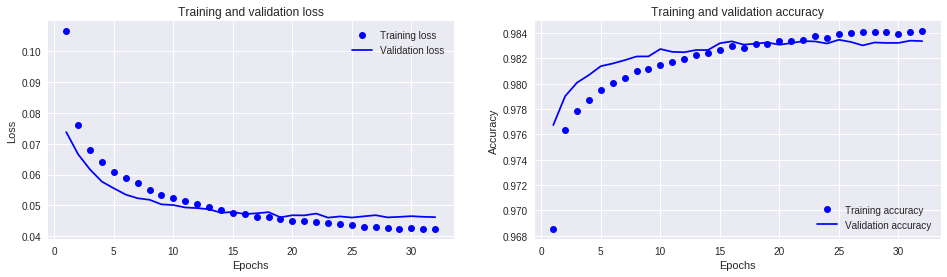

In [0]:
plot_history(history)

In [0]:
print(evaluate_on_test(model))

31915/31915 [==============================] - 53s 2ms/step
([0.04452803738236651, 0.983534375160405], 0.9836058187101502)
